In [30]:
import matplotlib.pyplot as plt
import torch
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
import numpy as np
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints, store_param, transform, un_transform
from mpl_toolkits import mplot3d
# from matplotlib import cm
from alse.print_workflow.read_excel import read_excel
from alse.print_workflow.init_model import initialize_models
from alse.one_iter_eci import one_iter_eci
from alse.print_workflow.generate_test_points import generate_test_points

In [31]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

Read data

In [32]:
X, width, pow_cap, adhere = read_excel()

Name for the excel sheets are hardcoded in this version
Spot size is hardcoded in this version


In [33]:
import ipympl

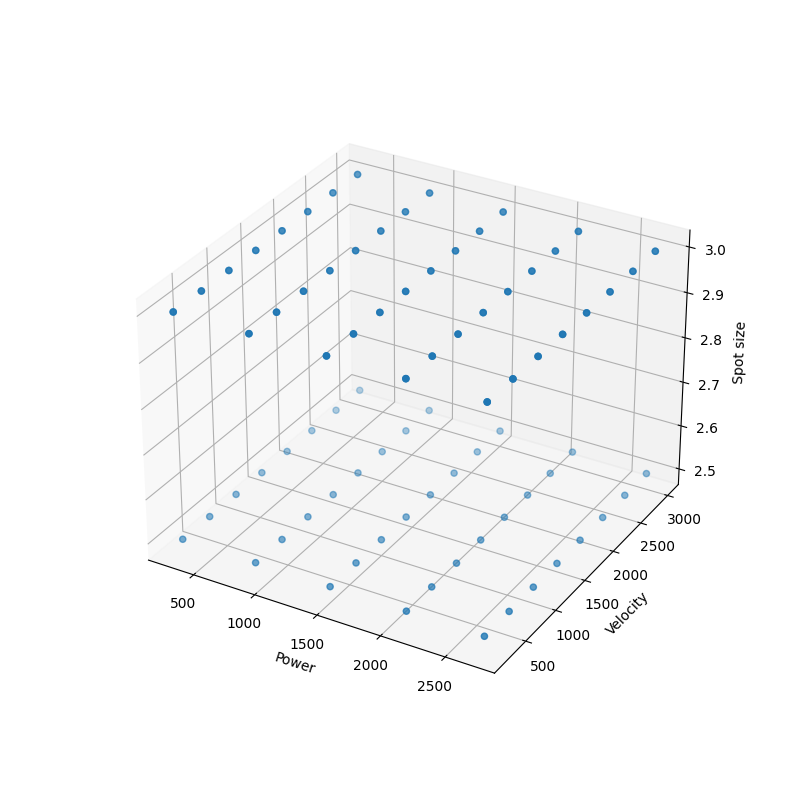

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
ax.set_zlabel("Spot size")
# ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
img = ax.scatter(X[:,0], X[:,1], X[:,2])
# fig.colorbar(img)
plt.show()

In [35]:
# Store for un_transform later
xrange_list, xmin_list = store_param(X, 3)

In [36]:
X = transform(X, 3)

# You can verify the Normalization is correct by undoing the above step and comparing to original data
# X = un_transform(X, xrange_list, xmin_list, 4) 

In [37]:
list_of_models = initialize_models(X, width, pow_cap, adhere) # You can put in arbitrary amount of output parameters

In [38]:
punchout_radius = 0.1
bounds = torch.tensor([[0, 0, 0], [1, 1, 1]], **tkwargs) # Because we normalized
lb, ub = bounds


In [39]:
constraints = [("gt", 0.3), ("gt", 20), ("gt", 0.1)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std

In [40]:
# How many new points do we want
num_pred = 3
Ytemp = [width, pow_cap, adhere] #Store temps for test point generation

In [41]:
X = generate_test_points(X, num_pred, Ytemp, constraints, punchout_radius, bounds)
X = un_transform(X, xrange_list, xmin_list, 3)

C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\botorch\fit.py:148: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(w.message, w.category)
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\botorch\fit.py:148: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(w.message, w.category)
C:\Users\Leo\AppData\Roaming\Python\Python39\site-packages\gpytorch\utils\cholesky.py:40: Num

In [42]:
new_N_points = X[-num_pred:]
for i in range(new_N_points.shape[0], 0, -1):
    new_power = round(X[-i][0].item(), 2)
    new_velocity = round(X[-i][1].item(), 2)
    new_spotsize = round(X[-i][2].item(), 2)
    # new_feedrate = round(X[-i][3].item(), 2)
    print(f"New X_{new_N_points.shape[0]+1-i}: Power: {new_power}W, Velocity: {new_velocity}mm/min, Spot size: {new_spotsize}mm")

New X_1: Power: 1873.13W, Velocity: 703.87mm/min, Spot size: 2.51mm
New X_2: Power: 2084.59W, Velocity: 1759.07mm/min, Spot size: 2.75mm
New X_3: Power: 1803.33W, Velocity: 2486.93mm/min, Spot size: 2.7mm


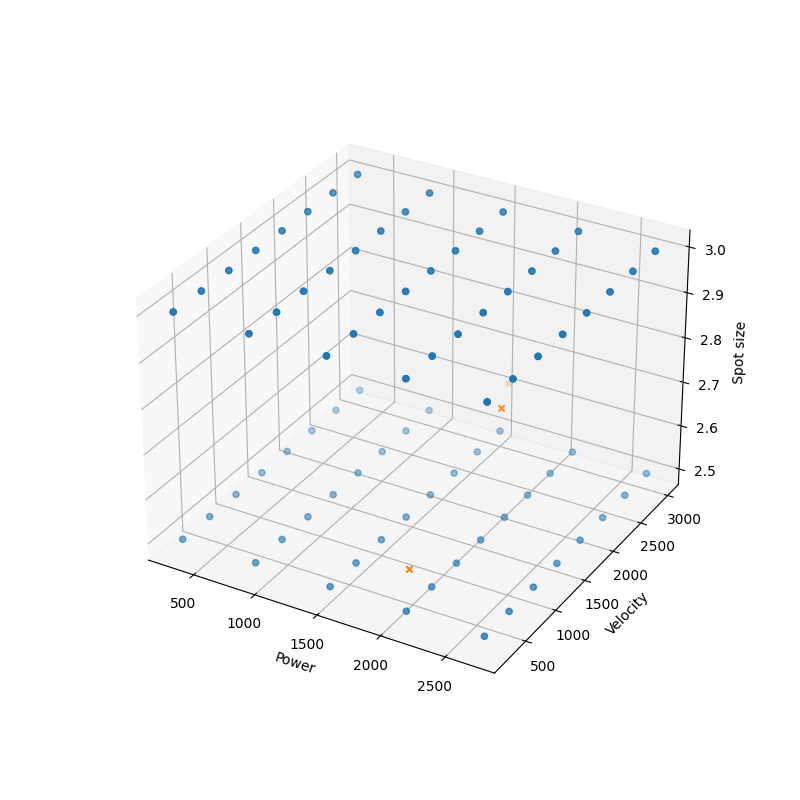

In [43]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
ax.set_zlabel("Spot size")
# ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3])
img = ax.scatter(X[:-num_pred,0], X[:-num_pred,1], X[:-num_pred,2])
img = ax.scatter(X[-num_pred:,0], X[-num_pred:,1], X[-num_pred:,2], marker = "x")
# fig.colorbar(img)
plt.show()